<a href="https://colab.research.google.com/github/tamangmilan/nn-pytorch/blob/main/nnpytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building Neural Network: With Real-World Dataset Using PyTorch**

**A Step-by-Step Guide to Build and Train Neural Network with FitBit Fitness Tracker Dataset**


By the end of this post, you'll be able to build your own Neural Network model, train your model with FitBit Fitness Tracker Dataset which is a real world dataset obtain from Kaggle.

And finally, given a new set of user activity feature like TotalSteps, TotalDistance, VeryActiveMinutes, your model can use its intelligence to predict the total calory burn which is the main goal of the model.

You can easily achieve all above with following 6 simple steps.

1. Import required libraries
2. Load and prepare the data
3. Define the model
4. Train and evaluate the model
5. Analyse the training and evaluation result
6. Make prediction on new data

Pre-requisite: You should have basic knowledge of Python, PyTorch and Neural Network basic concept to be able to follow through this post more effectively.

Lets get started.

## **Step 1: Import required libraries**

The firs step is to import the required classes, functions and modules given below. More details on each items will be provided during respective implementation later in this post. Before running the import code below, make sure you have the latest version of python and PyTorch installed. I'm using google colab notebook for this project and will share my google colab notebook at the end of this post.

In [1]:
# Import required libraries

import torch
import pandas as pd
import numpy as np

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## **Step 2: Load and prepare the data**

 First of all, download FitBit Fitness Tracker Dataset here. Load the dataset file [dailyActivity_merged.csv] using panda into the DataFrame variable as below and verify the data by visualizing it.


In [2]:
fitbit_df = pd.read_csv("/content/dailyActivity_merged.csv")
fitbit_df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [3]:
# The number of features in the above dataframe are quite alot. For our training purpose, we will reduce the number of features to 6. However, it is not advisable to reduce features for application that will be used in production. The model will learn better with more features thus enhance the accuracy further.

features = [ 'TotalSteps', 'TotalDistance','VeryActiveDistance', 'ModeratelyActiveDistance','VeryActiveMinutes', 'FairlyActiveMinutes','Calories']
fitbit_df = fitbit_df[features]

# All the feature value must be numerical. Network doesn't process non-numerical data.
fitbit_df.head()

,TotalSteps,TotalDistance,VeryActiveDistance,ModeratelyActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,Calories
0,13162,8.50,1.88,0.55,25,13,1985
1,10735,6.97,1.57,0.69,21,19,1797
2,10460,6.74,2.44,0.40,30,11,1776
3,9762,6.28,2.14,1.26,29,34,1745
4,12669,8.16,2.71,0.41,36,10,1863


Note: Since the data is from kaggle and is already pre-processed. I don't need to perform any pre-processing steps here. However, if you want to use this model to train on other raw data, you must perform some pre-processing operation to the data before further processing it for training. Data quality is very important for any model to give quality result. They say "Garbage in, Garbage out"

In [4]:
# Next, we'll split dataframe fields into input [X] and the output column "Calories" into variable [y] along with its value. Also, convert both variables to PyTorch tensor. Converting all data into PyTorch tensor will avoid potential datatype mismatch issue further.

X = torch.tensor(fitbit_df.drop(columns=["Calories"], axis=1).to_numpy(), dtype=torch.float)
y = torch.tensor(fitbit_df["Calories"].to_numpy(), dtype=torch.long)

In [5]:
# Verify X, y value
print("Input tensors: ", X[:5], "\n")
print("Output tensors: ", y[:5], "\n\n")

print("Shape of input tensor: ", X.shape)
print("Shape of ouput tensor: ", y.shape)

Input tensors:  tensor([[1.3162e+04, 8.5000e+00, 1.8800e+00, 5.5000e-01, 2.5000e+01, 1.3000e+01],
        [1.0735e+04, 6.9700e+00, 1.5700e+00, 6.9000e-01, 2.1000e+01, 1.9000e+01],
        [1.0460e+04, 6.7400e+00, 2.4400e+00, 4.0000e-01, 3.0000e+01, 1.1000e+01],
        [9.7620e+03, 6.2800e+00, 2.1400e+00, 1.2600e+00, 2.9000e+01, 3.4000e+01],
        [1.2669e+04, 8.1600e+00, 2.7100e+00, 4.1000e-01, 3.6000e+01, 1.0000e+01]]) 

Output tensors:  tensor([1985, 1797, 1776, 1745, 1863]) 


Shape of input tensor:  torch.Size([940, 6])
Shape of ouput tensor:  torch.Size([940])


In [6]:
# Now, in preparation for training, validation and testing the model, we'll split the dataset into train - 80%, validation - 10% and test-10%. We'll use train_test_split function from sklearn.model_selection module to perform the split.

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, test_size=0.5, random_state=42)

# Shape of dataset before split
print("Shape of input tensor: ", X.shape)
print("Shape of ouput tensor: ", y.shape, "\n")

# Shape of train, val, and test dataset after split. The sum total is same as original dataset.
# And each dataset still has 6 features which is the expected result
print("Train input: ", X_train.shape, "Train output: ", y_train.shape)
print("Val input: ", X_val.shape, "Val output: ", y_val.shape)
print("Test input: ", X_test.shape, "Test output: ", y_test.shape)



Shape of input tensor:  torch.Size([940, 6])
Shape of ouput tensor:  torch.Size([940]) 

Train input:  torch.Size([752, 6]) Train output:  torch.Size([752])
Val input:  torch.Size([94, 6]) Val output:  torch.Size([94])
Test input:  torch.Size([94, 6]) Test output:  torch.Size([94])


Features normalization: If you noticed the feature TotalSteps has value in the range of 4 digit and feature such as TotalDistance, VeryActiveDistance has value in the range of 1 digit. This huge difference in range will impact the training process not being smooth and might even brings divergence if not taken into consideration. Hence, we solve this by performing data normalization.

In [7]:
# Calculate mean
mean_train = X_train.mean(dim=0)
mean_val = X_val.mean(dim=0)
mean_test = X_test.mean(dim=0)

# Calculate standard deviation
std_train = X_train.std(dim=0)
std_val = X_val.std(dim=0)
std_test = X_test.std(dim=0)

# apply mean and std to the input dataset
X_train = (X_train - mean_train)/ std_train
X_val = (X_val - mean_val)/ std_val
X_test = (X_test - mean_test)/ std_test

In [8]:
print("Normalized X_train: ", X_train[:5], "\n")
print("Normalized X_val: ",X_val[:5], "\n")
print("Normalized X_train: ",X_test[:5], "\n")

Normalized X_train:  tensor([[-0.7593, -0.6997, -0.5467, -0.3020, -0.6219, -0.3347],
        [ 2.0021,  2.6591,  3.1946, -0.3020,  1.3290, -0.2848],
        [-1.4722, -1.3729, -0.5720, -0.6559, -0.6519, -0.6840],
        [ 0.3837,  0.4537, -0.0732, -0.4618, -0.1117, -0.4345],
        [ 0.0981,  0.2161, -0.3226,  1.6382, -0.3818,  1.4617]]) 

Normalized X_val:  tensor([[ 0.1610,  0.0433, -0.4913, -0.2763, -0.5920, -0.1751],
        [ 0.8919,  0.8510,  1.2233,  0.8606,  0.7055,  0.9937],
        [ 0.4630,  0.5132,  0.6823,  0.2816,  3.1563,  1.2372],
        [ 0.8296,  0.6422,  1.4158,  0.3027,  1.9309,  1.0424],
        [-1.0902, -0.9855, -0.4913, -0.5078, -0.5920, -0.5647]]) 

Normalized X_train:  tensor([[ 0.2477,  0.1251, -0.5565,  0.3802, -0.5782,  0.3463],
        [ 0.9586,  1.1760,  1.6955, -0.0067,  2.7202, -0.1255],
        [ 0.1309, -0.0063,  0.1472,  0.4598,  0.0458,  0.0842],
        [ 1.0478,  0.8070,  0.5695, -0.4049,  0.4916, -0.3351],
        [-0.4628, -0.4004, -0.6081, -

In [9]:
#Wrapping train, validation and test tensors into Tensor Dataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)



In [10]:
# show how train_dataset looks like
print(train_dataset[0])

(tensor([-0.7593, -0.6997, -0.5467, -0.3020, -0.6219, -0.3347]), tensor(2580))


In [11]:
len(test_dataset.tensors[0])

94

DataLoader combines a dataset and a sampler, and provides an iterable over the given dataset. If training data is very huge, iterating over single training data will take alot of time and training all data at once will not be practically possible due to the resource constraint. DataLoader solved this problem by allowing to define the batch size which can enable model to training multiple training data at once in batches. We'll create dataloader each for train, validation and test dataset and define batch_size as 10. shuffle=True helps shuffle the occurence of data in the batch to make training and learning better.

In [12]:
# Creating dataloader for each train, val and test dataset
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset.tensors[0]), shuffle=False, drop_last=True)

# showing first batch of train_loader
for X, y in train_loader:
  print("Shape of first batch of train_loader input : ", X.shape)
  print("Shape of first batch of train_loader output : ", y.shape)
  break

Shape of first batch of train_loader input :  torch.Size([10, 6])
Shape of first batch of train_loader output :  torch.Size([10])


### **Step 3: Define the model**

We're defining a functional model from PyTorch nn.Module. There is no specific rule to dictate the number of layers and the number of nodes in each layers. Generally, it takes many rounds of trial and error to find the right fit to each use cases. One rule of thumb is that the network should be small enough for processing fast and should be large enough to solve the intended problem with high accuracy.
Here, our  model has 3 layers, 3 activations and 1 output layer
The model's first layer, layer1 takes  in_feature value from input data. It should be total number of features or input vectors dimension which is 6.  (It can be obtained as, input_size = X_train.shape[1])
The first layer - layer1 has 64 nodes.
layer1 is followed by first Activation layer - activation1. We're using ReLU as an activation function which is popular choice in terms of its performance and also avoids vanishing gradient problem. ReLU provides non-linearity to the linear output from previous layer which is important for model for better learning during training.
The second layer - layer2 has 64 nodes.
Another activation layer - activation2  is added after layer2
The third layer is added after activation2, layer3 has 32 nodes.
Another activation layer activation3 is added after layer3
The output layer has 1 node since we're dealing with regression task here.

In [16]:
# Define the model

class fitbit_model(nn.Module):
  def __init__(self, input_features, output_class):
    super(fitbit_model, self).__init__()
    self.layer1 = nn.Linear(in_features=input_features, out_features=64)
    self.activation1 = nn.ReLU()
    self.layer2 = nn.Linear(in_features=64, out_features=64)
    self.activation2 = nn.ReLU()
    self.layer3 = nn.Linear(in_features=64, out_features=32)
    self.activation3 = nn.ReLU()
    self.output = nn.Linear(in_features=32, out_features=output_class)

  def forward(self, x):
    x = self.activation1(self.layer1(x))
    x = self.activation2(self.layer2(x))
    x = self.activation3(self.layer3(x))
    return self.output(x)


All the layers has been defined inside the constructor of fitbit_model class.
super(fitbit_model, self).__init__(), this is a parent class nn.Module constructor, is called to bootstrap fitbit_model model
forward function will take input tensor and returns model's output tensor.

Next, initialize the model by providing input features and output class to the fitbit_model constructor. Initially, the weights and bias parameters are automatically initialized by model. These parameters value will be subsequently updated during training.

In [17]:
input_features = X_train.shape[1]
output_class = 1
model = fitbit_model(input_features, output_class)

In [27]:
print("Model Schema\n")
print(model)

print("\nModel initial weights values for layer1")
print(model.layer1.weight[:2])
print("Weight shape on layer1: ", model.layer1.weight.shape)

print("\nModel initial bias values for layer1")
print(model.layer1.bias[:2])
print("Bias shape on layer1: ", model.layer1.bias.shape)

Model Schema

fitbit_model(
  (layer1): Linear(in_features=6, out_features=64, bias=True)
  (activation1): ReLU()
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (activation2): ReLU()
  (layer3): Linear(in_features=64, out_features=32, bias=True)
  (activation3): ReLU()
  (output): Linear(in_features=32, out_features=1, bias=True)
)

Model initial weights values for layer1
tensor([[-0.2197,  0.0392, -0.1926,  0.2334,  0.2295,  0.3299],
        [-0.2867, -0.0068,  0.1312,  0.1713,  0.1160, -0.2773]],
       grad_fn=<SliceBackward0>)
Weight shape on layer1:  torch.Size([64, 6])

Model initial bias values for layer1
tensor([-0.0813,  0.2138], grad_fn=<SliceBackward0>)
Bias shape on layer1:  torch.Size([64])


### **Step 4: Train and evaluate the model**

loss_fn = nn.HuberLoss(delta=0.5): Huber Loss is a loss function used in robust regression. It is a combination of both MSE and MAE. delta is the hyperparameter to define the range for MAE and MSE which can be iterative to make sure the correct delta value.

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001): Adam is one of the most commonly used optimization algorithms that hold the current state and will update the parameters based on the computed gradients. It take [(model.parameters) - learnable parameters (W and b)] and learning rate which determine how fast or slow the model should learn in order to achieve smooth convergence. Hence, learning rate value should be carefully choosen.

n_epochs = 100: The entire training, validation cycle will run for 100 times

Finally, train and evaluate the model for 100 epochs.

In [28]:
# Train and evaluate the model

# Huber Loss is a loss function used in robust regression. It is a combination of both MSE and MAE. delta is the hyperparameter to define the range for MAE and MSE which can be iterative to make sure the correct delta value.
loss_fn = nn.HuberLoss(delta=0.5)

# Adam is one of the most commonly used optimization algorithms that hold the current state and will update the parameters based on the computed gradients. It take model parameters and learning rate which determine how fast or slow the model should learn in order to achieve smooth convergence. Hence, learning rate value should be carefully choosen.
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


# collecting metrics
train_losses = []
val_losses = []

# Training
n_epochs = 100

for epoch in range(n_epochs):

  # Train the model
  model.train()
  train_loss = 0.0
  for x_batch, y_batch in train_loader:
    # forward pass
    y_pred = model(x_batch)
    y_pred = torch.squeeze(y_pred)
    y_batch = y_batch.float()
    loss = loss_fn(y_pred, y_batch)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update weights
    optimizer.step()
    train_loss += loss.item()
  train_losses.append(train_loss / len(train_loader))

  # Evaluate the model
  model.eval()
  val_loss = 0.0
  with torch.inference_mode():
    for x_batch, y_batch in val_loader:
      y_pred = model(x_batch)
      y_pred = torch.squeeze(y_pred)
      y_batch = y_batch.float()
      loss = loss_fn(y_pred, y_batch)

      val_loss += loss.item()
    val_losses.append(val_loss/len(val_loader))

  print(f'Epoch [{epoch+1}/{n_epochs}]: Train Loss: {train_losses[-1]:.2f}, Val Loss: {val_losses[-1]:.2f}')


Epoch [1/100]: Train Loss: 1147.43, Val Loss: 1116.25
Epoch [2/100]: Train Loss: 1041.71, Val Loss: 841.27
Epoch [3/100]: Train Loss: 534.10, Val Loss: 378.15
Epoch [4/100]: Train Loss: 367.34, Val Loss: 317.46
Epoch [5/100]: Train Loss: 311.24, Val Loss: 271.18
Epoch [6/100]: Train Loss: 271.05, Val Loss: 245.91
Epoch [7/100]: Train Loss: 247.05, Val Loss: 234.65
Epoch [8/100]: Train Loss: 234.41, Val Loss: 226.61
Epoch [9/100]: Train Loss: 225.55, Val Loss: 217.46
Epoch [10/100]: Train Loss: 219.92, Val Loss: 210.66
Epoch [11/100]: Train Loss: 215.17, Val Loss: 207.16
Epoch [12/100]: Train Loss: 212.30, Val Loss: 202.97
Epoch [13/100]: Train Loss: 208.80, Val Loss: 202.06
Epoch [14/100]: Train Loss: 204.90, Val Loss: 195.04
Epoch [15/100]: Train Loss: 204.00, Val Loss: 198.28
Epoch [16/100]: Train Loss: 200.91, Val Loss: 194.26
Epoch [17/100]: Train Loss: 198.10, Val Loss: 196.02
Epoch [18/100]: Train Loss: 197.96, Val Loss: 194.62
Epoch [19/100]: Train Loss: 195.33, Val Loss: 193.56

### 6. **Analyse the training and evaluation result**

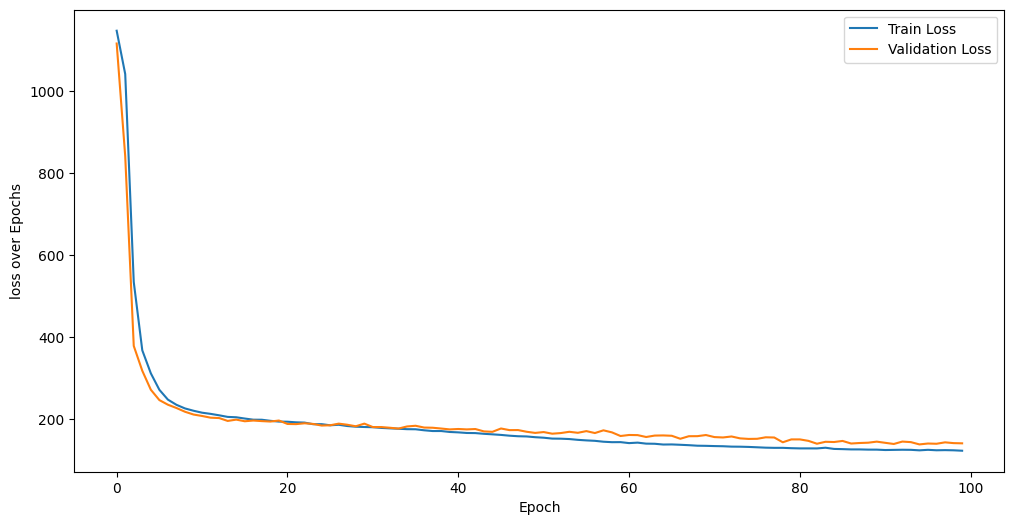

In [29]:
plt.figure(figsize=(12,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.ylabel("loss over Epochs")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Both train loss and validation loss has been reduce significantly after 20 epochs. This result is considered quite good.
# To get even better result, you can try increasing training data and number of epochs

### 6. **Prediction on new data**

Finally, we've come to the stage which we've been waiting for. In order to find out how well our model is performing on new dataset. We've already prepared test_dataset earlier which is a toally a new dataset which we've not used until at this point. lets use it to make prediction.

In [30]:
# Predicting the test dataset
model.eval()
pred_val = []
target_val = []

with torch.inference_mode():
  for x_test, y_test in test_loader:
    y_test_pred = model(x_test)
    pred_val.append(y_test_pred)
    target_val.append(y_test)

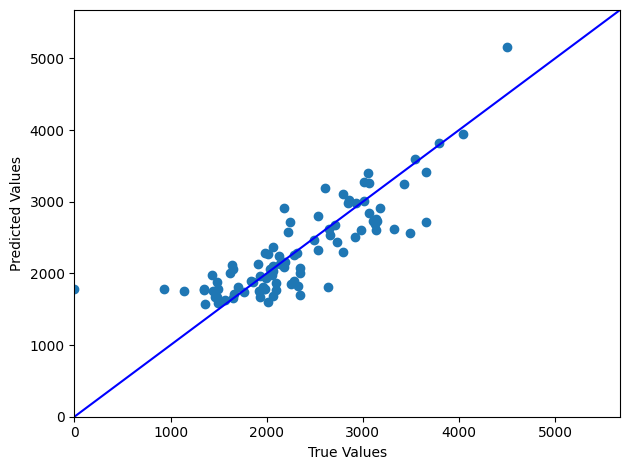

In [32]:
labels = torch.cat(target_val).flatten().tolist()
predictions = torch.cat(pred_val).flatten().tolist()

plt.scatter(labels, predictions)

max_lim = max(max(predictions), max(labels))
max_lim += max_lim * 0.1

plt.xlim(0, max_lim)
plt.ylim(0, max_lim)

plt.plot([0,max_lim], [0,max_lim], "b-")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.tight_layout()

In this scatter plot, you can notice that our models predicted values and true values are quite closely located. Hence it proves that the model we have built and trained generalized fairly well on new test dataset.